<a href="https://colab.research.google.com/github/VadimFarutin/deep-unsupervised-learning/blob/hw02/hw02_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW02

## 1 Flows in 2D

### Imports and Data

In [0]:
%%capture
!pip install wandb -q

In [0]:
import wandb
!wandb login

In [0]:
from collections import defaultdict
from tqdm import tnrange, tqdm_notebook
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import random

import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.distributions import Normal, Uniform

In [0]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [52]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [0]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
              -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [0]:
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(69999, 2) (69999,)
(10000, 2) (10000,)
(20000, 2) (20000,)


### Autoregressive flow

In [0]:
class MyCDFParamsConst(nn.Module):
    def __init__(self, k):
        super(MyCDFParamsConst, self).__init__()
        self.pi = nn.Parameter(torch.randn(k, requires_grad=True))
        self.mu = nn.Parameter(torch.randn(k, requires_grad=True))
        self.sigma = nn.Parameter(torch.randn(k, requires_grad=True))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        pi = self.softmax(self.pi)
        mu = self.mu
        sigma = self.sigma
        
        return pi, mu, sigma

    def __call__(self, x):
        return self.forward(x)

In [0]:
class MyCDFParams(nn.Module):
    def __init__(self, k, hidden_size):
        super(MyCDFParams, self).__init__()
        self.k = k

        self.pi = nn.Sequential(nn.Linear(1, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, k),
                                nn.Softmax(dim=1))
        self.mu = nn.Sequential(nn.Linear(1, hidden_size),
                                nn.ReLU(),
                                nn.Linear(hidden_size, k))
        self.sigma = nn.Sequential(nn.Linear(1, hidden_size),
                                   nn.ReLU(),
                                   nn.Linear(hidden_size, k))

    def forward(self, x):
        pi = self.pi(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        
        return pi, mu, sigma
    
    def __call__(self, x):
        return self.forward(x)

In [0]:
class MyFlow(nn.Module):
    def __init__(self, k, hidden_size):
        super(MyFlow, self).__init__()
        self.k = k
        self.params1 = MyCDFParamsConst(k).to(DEVICE)
        self.params2 = MyCDFParams(k, hidden_size).to(DEVICE)

    def forward(self, x):
        x1, x2 = x[:, 0], x[:, 1]

        pi1, mu1, sigma1 = self.params1(x1.view(-1, 1))
        pi2, mu2, sigma2 = self.params2(x1.view(-1, 1))

        p1 = torch.zeros(x.shape[0]).to(DEVICE)
        p2 = torch.zeros(x.shape[0]).to(DEVICE)
        
        for i in range(self.k):
            # could be NaN without exp, possibly because of log(scale) inside log_prob()
            p1 += pi1[i] * Normal(mu1[i], torch.exp(sigma1[i])).log_prob(x1).exp()
            p2 += pi2[:, i] * Normal(mu2[:, i], torch.exp(sigma2[:, i])).log_prob(x2).exp()

        return p1 * p2 # * 1

    def latent(self, x):
        x1, x2 = x[:, 0], x[:, 1]

        pi1, mu1, sigma1 = self.params1(x1.view(-1, 1))
        pi2, mu2, sigma2 = self.params2(x1.view(-1, 1))

        z1 = torch.zeros(x.shape[0]).to(DEVICE)
        z2 = torch.zeros(x.shape[0]).to(DEVICE)
            
        for i in range(self.k):
            z1 += pi1[i] * Normal(mu1[i], torch.exp(sigma1[i])).cdf(x1)
            z2 += pi2[:, i] * Normal(mu2[:, i], torch.exp(sigma2[:, i])).cdf(x2)

        return z1, z2

    def inverse(self, z):
        z1, z2 = z[:, 0], z[:, 1]

        pi1, mu1, sigma1 = self.params1(z1.view(-1, 1))
        x1 = torch.zeros(z.shape[0]).to(DEVICE)
        for i in range(z.shape[0]):
            j = np.random.choice(self.k, p=pi1.detach().numpy())
            x1[i] = Normal(mu1[j], torch.exp(sigma1[j])).icdf(z1[i])

        pi2, mu2, sigma2 = self.params2(x1.view(-1, 1))
        x2 = torch.zeros(z.shape[0]).to(DEVICE)
        for i in range(z.shape[0]):
            j = np.random.choice(self.k, p=pi2[i].detach().numpy())
            x2[i] = Normal(mu2[i, j], torch.exp(sigma2[i, j])).icdf(z2[i])

        return x1, x2

    def __call__(self, x):
        return self.forward(x)

In [0]:
def MyNLLLoss(y):
    return -torch.mean(torch.log(y)) / 2

In [0]:
def fit(model, train, val, test, optimizer, loss_function, epoch_cnt, batch_size):
    train_loader = torch.utils.data.DataLoader(torch.from_numpy(train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.from_numpy(val), batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(torch.from_numpy(test), batch_size=batch_size)
    train_loss_values = []
    val_loss_values = []
            
    for epoch in tnrange(epoch_cnt, desc='Epoch'):
        for batch_data in train_loader:
            x = batch_data.float().to(DEVICE)
            optimizer.zero_grad()
            output = model(x)
            loss = loss_function(output)
            train_loss_values.append(loss)
            loss.backward()
            optimizer.step()

            wandb.log({"Train Loss": loss})

        loss_values = []
        for batch_data in val_loader:
            x = batch_data.float().to(DEVICE)
            output = model(x)
            loss = loss_function(output)
            loss_values.append(loss.item())
        val_loss_values.append(np.mean(np.array(loss_values)))

        wandb.log({"Validation Loss": val_loss_values[-1]})

    loss_values = []
    for batch_data in test_loader:
        x = batch_data.float().to(DEVICE)
        output = model(x)
        loss = loss_function(output)
        loss_values.append(loss.item())

    print("Test set loss: {:.3f}".format(np.mean(np.array(loss_values))))
    
    return train_loss_values, val_loss_values 


In [132]:
wandb.init(entity="vadim-farutin", project="HSE-DUL-HW02-1")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

config = wandb.config
config.k = 8
config.hidden_size = 128
config.lr = 1e-2
config.batch_size = 512
config.epochs = 5

In [0]:
model = MyFlow(config.k, config.hidden_size)
model = model.float()
model = model.to(DEVICE)

In [0]:
loss_function = MyNLLLoss
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [135]:
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer, loss_function, config.epochs, config.batch_size)


Test set loss: 0.681


In [0]:
def plot_loss_values(train_loss_values, val_loss_values):
    plt.plot(np.arange(len(train_loss_values)), train_loss_values, color='blue', label='train')
    plt.plot(np.arange(0, len(train_loss_values), len(train_loss_values) / config.epochs), val_loss_values, color='red', label='validation')
    plt.legend()
    plt.title("Loss values")
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()

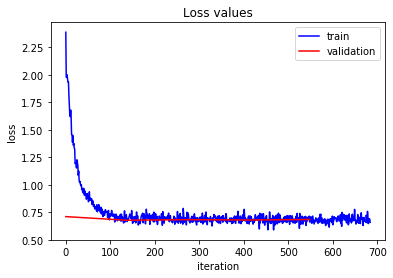

In [137]:
plot_loss_values(train_loss_values, val_loss_values)

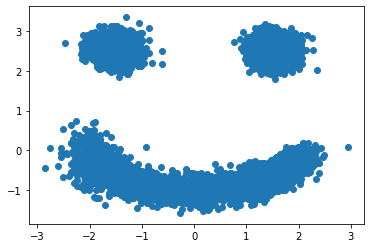

In [138]:
low = torch.tensor([0.0]).to(DEVICE)
high = torch.tensor([1.0]).to(DEVICE)
z = Uniform(low, high).rsample((10000, 2))
x1, x2 = model.inverse(z)
x1 = x1.cpu().detach().numpy()
x2 = x2.cpu().detach().numpy()
plt.figure()
plt.scatter(x1, x2)

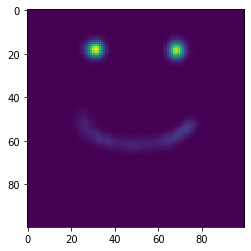

In [139]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().to(DEVICE)
pdf = model(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

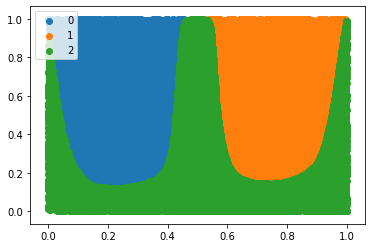

In [140]:
x = torch.from_numpy(X).float().to(DEVICE)
z1, z2 = model.latent(x)
z1 = z1.cpu().detach().numpy()
z2 = z2.cpu().detach().numpy()
plt.figure()
plt.scatter(z1[y == 0], z2[y == 0], label='0')
plt.scatter(z1[y == 1], z2[y == 1], label='1')
plt.scatter(z1[y == 2], z2[y == 2], label='2')
plt.legend()

### RealNVP

In [0]:
class MyCouplingLayer(nn.Module):
    def __init__(self, mask, hidden_size):
        super(MyCouplingLayer, self).__init__()
        self.mask = mask.clone()
        self.s = nn.Sequential(nn.Linear(2, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, 2),
                               nn.ReLU()).to(DEVICE)
        self.t = nn.Sequential(nn.Linear(2, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, 2)).to(DEVICE)

    def forward(self, x):
        z1 = self.mask * x
        s = self.s(z1)
        t = self.t(z1)
        log_prob = torch.sum((1 - self.mask) * s, dim=1).view(-1, 1)

        return log_prob

    def latent(self, x):
        z1 = self.mask * x
        s = self.s(z1)
        t = self.t(z1)
        z2 = (1 - self.mask) * (x * torch.exp(s) + t)

        return z1 + z2

    def inverse(self, z):
        x1 = self.mask * z
        s = self.s(x1)
        t = self.t(x1)
        x2 = (1 - self.mask) * (z - t) * torch.exp(-s)

        return x1 + x2
    
    def __call__(self, x):
        return self.forward(x)

In [0]:
class MyRealNVP(nn.Module):
    def __init__(self, hidden_size):
        super(MyRealNVP, self).__init__()
        mask = torch.tensor([[0, 1]]).to(DEVICE)

        self.layers = nn.Sequential(MyCouplingLayer(mask, hidden_size),
                                    MyCouplingLayer(1 - mask, hidden_size),
                                    MyCouplingLayer(mask, hidden_size),
                                    MyCouplingLayer(1 - mask, hidden_size),
                                    MyCouplingLayer(mask, hidden_size))

    def forward(self, x):
        log_prob = torch.zeros((x.shape[0], 1)).to(DEVICE)
        z = x

        for layer in self.layers:
            log_prob += layer(z)
            z = layer.latent(z)

        z = torch.sigmoid(z)
        log_prob += torch.log(z * (1 - z) + 1e-9).sum(dim=1).view(-1, 1)

        return log_prob.exp()

    def latent(self, x):
        z = x

        for layer in self.layers:
            z = layer.latent(z)
        
        z = torch.sigmoid(z)

        return z[:, 0], z[:, 1]

    def inverse(self, z):
        x = -torch.log(1 / z - 1)

        for layer in reversed(self.layers):
            x = layer.inverse(x)

        return x[:, 0], x[:, 1]

    def __call__(self, x):
        return self.forward(x)

In [158]:
wandb.init(entity="vadim-farutin", project="HSE-DUL-HW02-2")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

config = wandb.config
config.k = 8
config.hidden_size = 128
config.lr = 1e-3
config.batch_size = 512
config.epochs = 10

In [0]:
model = MyRealNVP(config.hidden_size)
model = model.float()
model = model.to(DEVICE)

In [0]:
loss_function = MyNLLLoss
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [199]:
train_loss_values, val_loss_values =\
    fit(model, X_train, X_val, X_test, optimizer, loss_function, config.epochs, config.batch_size)


Test set loss: 0.870


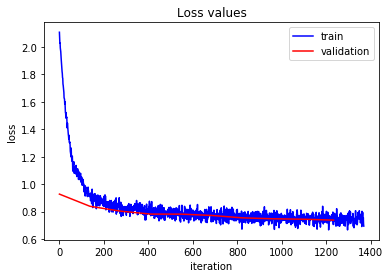

In [132]:
plot_loss_values(train_loss_values, val_loss_values)

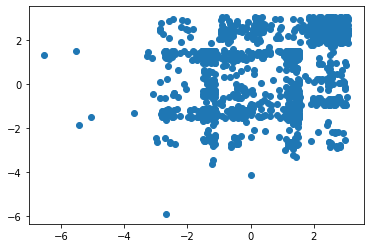

In [200]:
low = torch.tensor([0.0]).to(DEVICE)
high = torch.tensor([1.0]).to(DEVICE)
z = Uniform(low, high).rsample((1000, 2))
x1, x2 = model.inverse(z)
x1 = x1.cpu().detach().numpy()
x2 = x2.cpu().detach().numpy()
plt.figure()
plt.scatter(x1, x2)

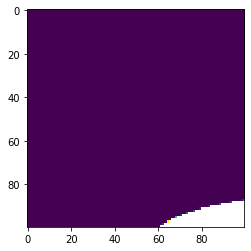

In [201]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float().to(DEVICE)
pdf = model(samples).cpu().detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

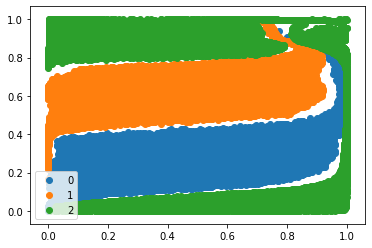

In [202]:
x = torch.from_numpy(X).float().to(DEVICE)
z1, z2 = model.latent(x)
z1 = z1.cpu().detach().numpy()
z2 = z2.cpu().detach().numpy()
plt.figure()
plt.scatter(z1[y == 0], z2[y == 0], label='0')
plt.scatter(z1[y == 1], z2[y == 1], label='1')
plt.scatter(z1[y == 2], z2[y == 2], label='2')
plt.legend()